## Imports
---

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

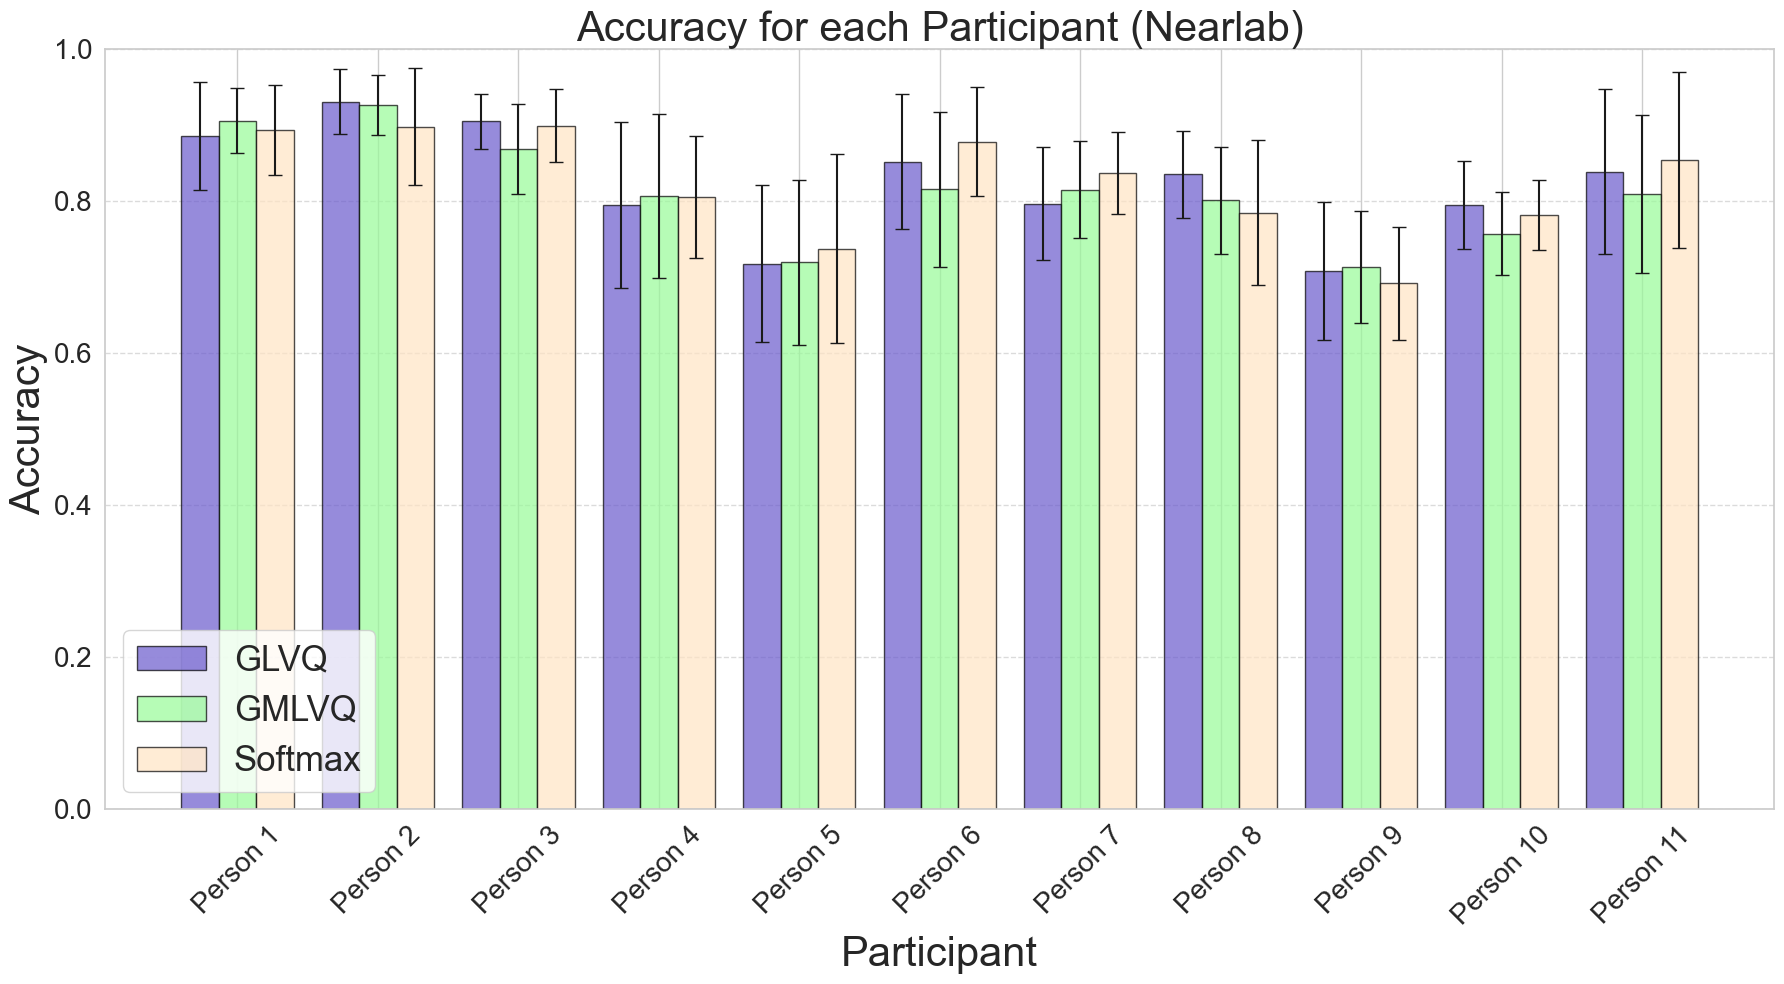

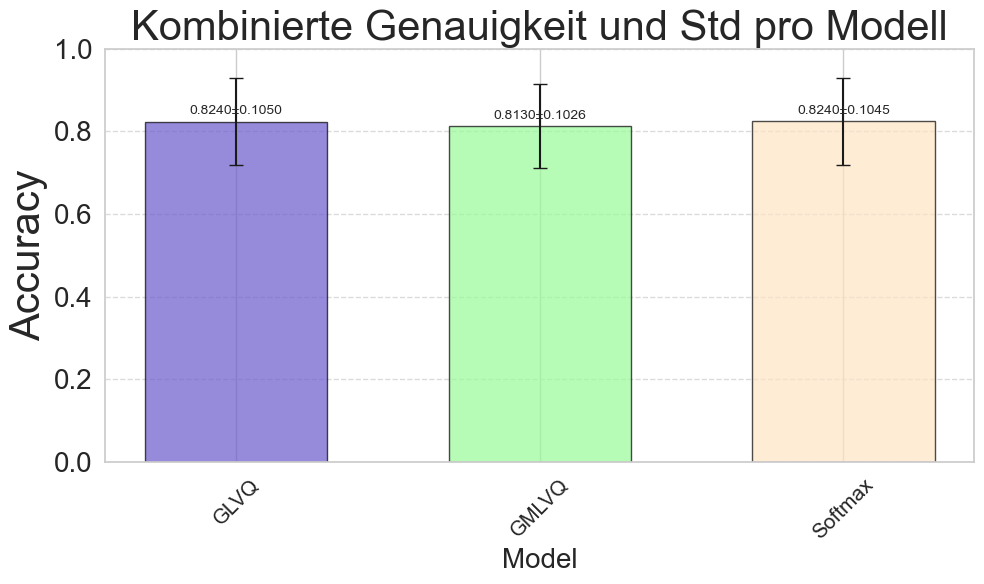

In [85]:

def collect_accuracies(root_dir, models=["GLVQ", "GMLVQ", "Softmax"]):
    """
    Runs through the root directory and collects the accuracy values from the training history CSV files

    Parameters:
    ----------
    root_dir : str
        Root directory containing the results of the training runs.
    models : list of str
        List of model names to search for in the subfolder names.
    """
    accuracies = {}
    
    # Check if root exists
    if not os.path.isdir(root_dir):
        print(f"Der angegebene root_dir existiert nicht oder ist kein Verzeichnis: {root_dir}")
        return accuracies

    # Run through all subfolders in the root directory
    for person_name in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_name)
        # Check if the current subfolder is a directory
        if os.path.isdir(person_path):
            accuracies[person_name] = {}
            # Run through all subfolders in the person directory
            for subfolder in os.listdir(person_path):
                subfolder_path = os.path.join(person_path, subfolder)
                # Check if the current subfolder is a directory and contains the word "history"
                if os.path.isdir(subfolder_path) and "history" in subfolder.lower():
                    # Check if the subfolder name contains the model name
                    for model in models:
                        if model.lower() in subfolder.lower():
                            model_name = model
                            model_found = True
                            break
                    if model_name not in accuracies[person_name]:
                        accuracies[person_name][model_name] = []
                    csv_file = os.path.join(subfolder_path, "training_history.csv")
                    
                    # Check if the CSV file exists
                    if os.path.isfile(csv_file):
                        df = pd.read_csv(csv_file)
                        if "accuracy" in df.columns:
                            # Extract the accuracy values and add them to the dictionary
                            acc_values = df["accuracy"].dropna().tolist()
                            accuracies[person_name][model_name].extend(acc_values)
    
    return accuracies

def plot_grouped_accuracies(
    data_dict,
    model_names=["GLVQ", "GMLVQ", "Softmax"],
    figsize=(15, 8),
    save_path=None,
    title_fontsize=16,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    xtick_fontsize=12,
    ytick_fontsize=12,
    legend_fontsize=12,
    text_fontsize=10
):
    """
    Erstellt ein gruppiertes Balkendiagramm mit mittlerer Genauigkeit und Standardabweichung pro Person und Modell.
    
    Parameters:
    ----------
    data_dict : dict
        Dictionary mit Struktur {Person: {Model: [Accuracies]}}.
    model_names : list of str, optional
        Liste der Modellnamen.
    figsize : tuple, optional
        Größe des Plots.
    save_path : str, optional
        Pfad zum Speichern des Plots. Wenn None, wird der Plot angezeigt.
    title_fontsize : int, optional
        Schriftgröße für den Titel.
    xlabel_fontsize : int, optional
        Schriftgröße für die x-Achsenbeschriftung.
    ylabel_fontsize : int, optional
        Schriftgröße für die y-Achsenbeschriftung.
    xtick_fontsize : int, optional
        Schriftgröße für die x-Achsen-Tick-Labels.
    ytick_fontsize : int, optional
        Schriftgröße für die y-Achsen-Tick-Labels.
    legend_fontsize : int, optional
        Schriftgröße für die Legende.
    text_fontsize : int, optional
        Schriftgröße für Text innerhalb des Plots.
    """
    person_names = sorted(data_dict.keys())
    num_persons = len(person_names)
    num_models = len(model_names)

    means = {model: [] for model in model_names}
    stds = {model: [] for model in model_names}
    
    for person in person_names:
        for model in model_names:
            acc = np.array(data_dict[person].get(model, []))
            if len(acc) > 0:
                means[model].append(np.mean(acc))
                stds[model].append(np.std(acc))
            else:
                means[model].append(0)
                stds[model].append(0)

    x = np.arange(num_persons)
    total_width = 0.8
    bar_width = total_width / num_models
    offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, num_models)
    
    # Farben für das Balkendiagramm
    colors = ["slateblue", "palegreen", "bisque"]
    
    plt.figure(figsize=figsize)
    
    for idx, model in enumerate(model_names):
        plt.bar(
            x + offsets[idx], 
            means[model], 
            width=bar_width, 
            yerr=stds[model],
            capsize=5, 
            label=model, 
            color=colors[idx], 
            edgecolor="black", 
            alpha=0.7
        )

    plt.xlabel("Participant", fontsize=xlabel_fontsize)
    plt.ylabel("Accuracy", fontsize=ylabel_fontsize)
    plt.title("Accuracy for each Participant (Nearlab)", fontsize=title_fontsize)
    plt.xticks(x, [f"Person {i+1}" for i in range(num_persons)], rotation=45, fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.ylim(0, 1)
    plt.legend(fontsize=legend_fontsize)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Gruppierter Plot gespeichert unter: {save_path}")
    else:
        plt.show()

def plot_combined_accuracies(
    data_dict,
    model_names=["GLVQ", "GMLVQ", "Softmax"],
    figsize=(10, 6),
    save_path=None,
    title_fontsize=16,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    xtick_fontsize=12,
    ytick_fontsize=12,
    legend_fontsize=12,
    text_fontsize=10
):
    """
    Erstellt ein kombiniertes Balkendiagramm mit mittlerer Genauigkeit und Standardabweichung pro Modell.
    
    Parameters:
    ----------
    data_dict : dict
        Dictionary mit Struktur {Person: {Model: [Accuracies]}}.
    model_names : list of str, optional
        Liste der Modellnamen.
    figsize : tuple, optional
        Größe des Plots.
    save_path : str, optional   
        Pfad zum Speichern des Plots. Wenn None, wird der Plot angezeigt.
    title_fontsize : int, optional
        Schriftgröße für den Titel.
    xlabel_fontsize : int, optional
        Schriftgröße für die x-Achsenbeschriftung.
    ylabel_fontsize : int, optional
        Schriftgröße für die y-Achsenbeschriftung.
    xtick_fontsize : int, optional
        Schriftgröße für die x-Achsen-Tick-Labels.
    ytick_fontsize : int, optional
        Schriftgröße für die y-Achsen-Tick-Labels.
    legend_fontsize : int, optional
        Schriftgröße für die Legende.
    text_fontsize : int, optional
        Schriftgröße für Text innerhalb des Plots.
    """
    combined_means = []
    combined_stds = []
    for model in model_names:
        all_acc = []
        for person in data_dict:
            all_acc.extend(data_dict[person].get(model, []))
        all_acc = np.array(all_acc)
        if len(all_acc) > 0:
            combined_means.append(np.mean(all_acc))
            combined_stds.append(np.std(all_acc))
        else:
            combined_means.append(0)
            combined_stds.append(0)
    x = np.arange(len(model_names))
    colors = ["slateblue", "palegreen", "bisque"]
    plt.figure(figsize=figsize)
    bars = plt.bar(
        x, 
        combined_means, 
        width=0.6, 
        yerr=combined_stds,
        capsize=5, 
        color=colors, 
        edgecolor="black", 
        alpha=0.7
    )
    
    plt.xlabel("Model", fontsize=xlabel_fontsize)
    plt.ylabel("Accuracy", fontsize=ylabel_fontsize)
    plt.title("Kombinierte Genauigkeit und Std pro Modell", fontsize=title_fontsize)
    plt.xticks(x, model_names, rotation=45, fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.ylim(0, 1)
    # Entferne die separate Legende, da nur ein Balken pro Modell ist
    # Stattdessen fügst du Beschriftungen direkt auf den Balken hinzu
    for bar, mean, std in zip(bars, combined_means, combined_stds):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.01, 
            f"{mean:.4f}±{std:.4f}",
            ha="center", 
            va="bottom", 
            fontsize=text_fontsize
        )
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Kombinierter Plot gespeichert unter: {save_path}")
    else:
        plt.show()

root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/basicEval"

model_names = ["GLVQ", "GMLVQ", "Softmax"]
    
all_accuracies_dict = collect_accuracies(root_directory, models=model_names)
plot_grouped_accuracies(all_accuracies_dict, model_names=model_names, figsize=(18, 10), save_path=None, xlabel_fontsize=30, xtick_fontsize=20, ytick_fontsize=20, ylabel_fontsize=30, title_fontsize=30, legend_fontsize=25)
plot_combined_accuracies(all_accuracies_dict, model_names=model_names, figsize=(10, 6), save_path=None, xlabel_fontsize=20, xtick_fontsize=15, ytick_fontsize=20, ylabel_fontsize=30, title_fontsize=30, legend_fontsize=25)


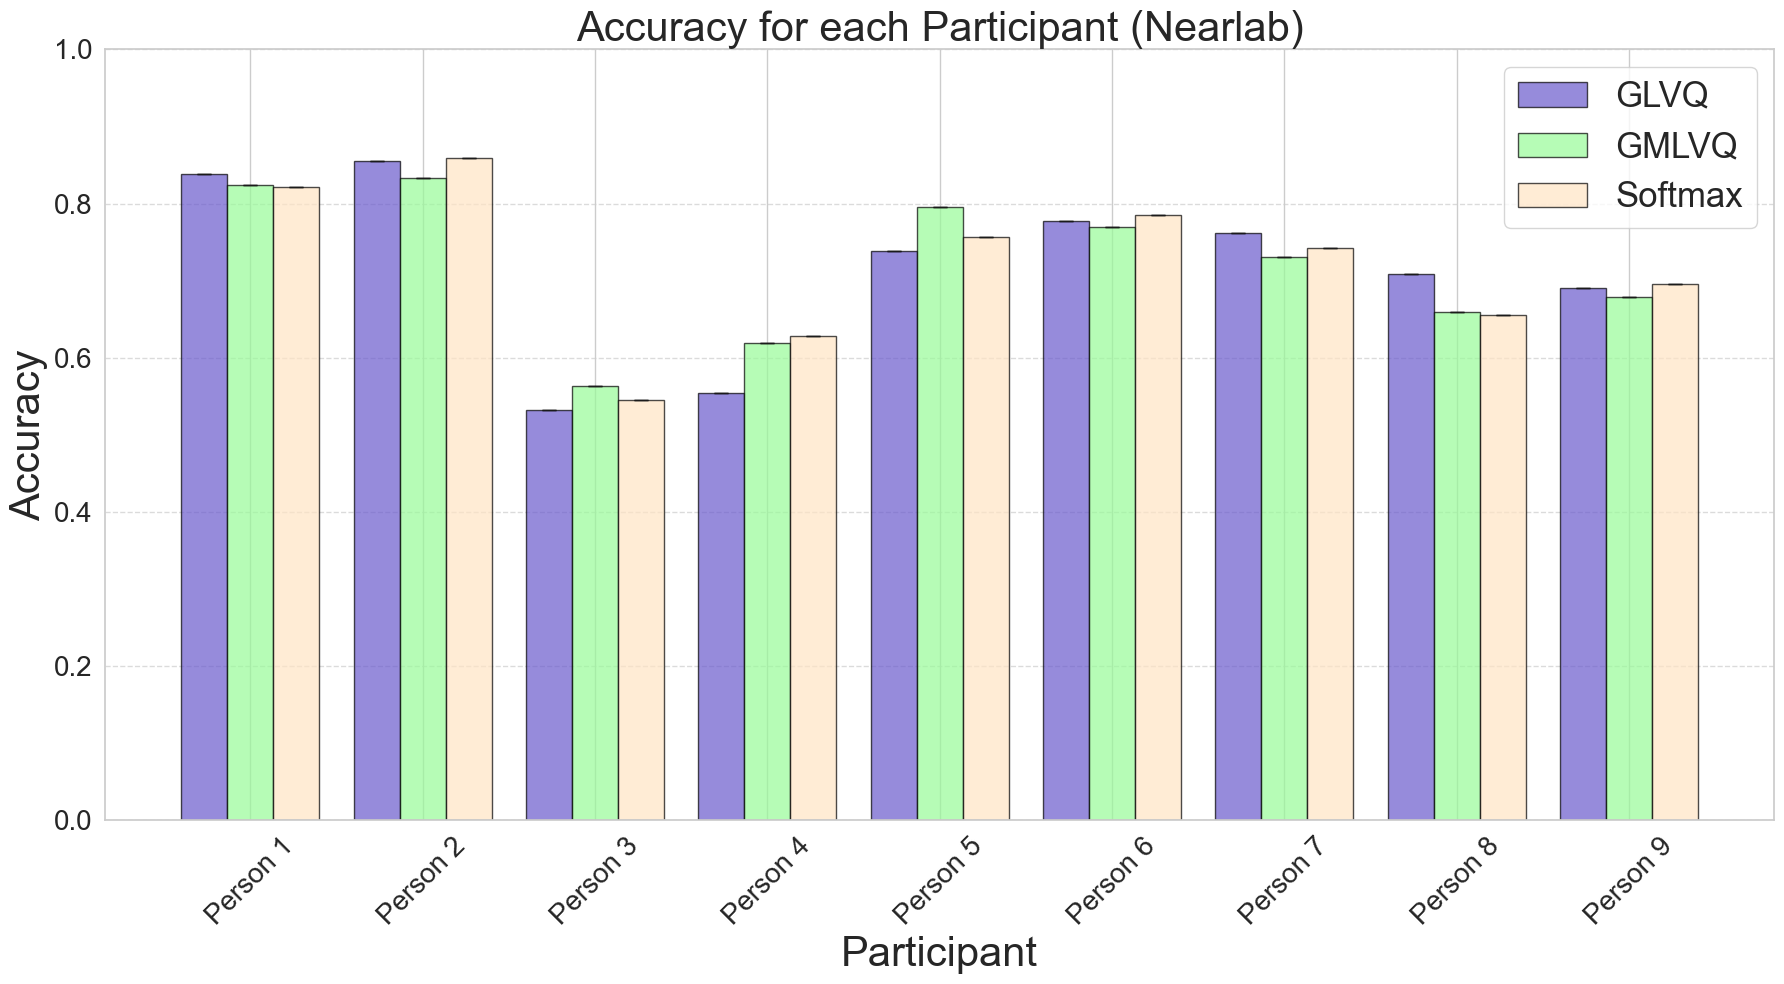

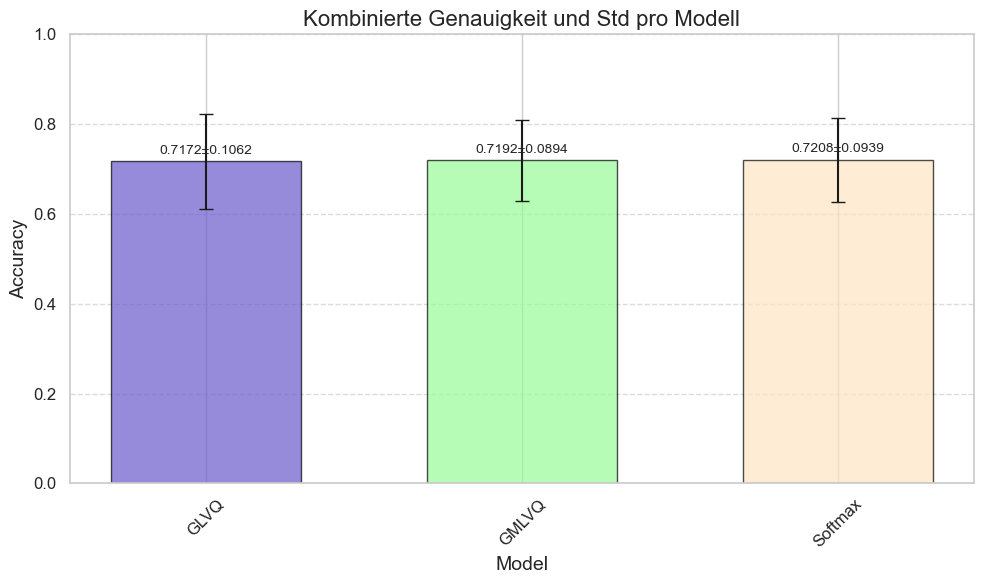

In [86]:
root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/subject"

model_names = ["GLVQ", "GMLVQ", "Softmax"]
    
all_accuracies_dict = collect_accuracies(root_directory, models=model_names)
plot_grouped_accuracies(all_accuracies_dict, model_names=model_names, figsize=(18, 10), save_path=None, xlabel_fontsize=30, xtick_fontsize=20, ytick_fontsize=20, ylabel_fontsize=30, title_fontsize=30, legend_fontsize=25)
plot_combined_accuracies(all_accuracies_dict, model_names=model_names, figsize=(10, 6), save_path=None)

In [ ]:
import os
import pandas as pd
import numpy as np

def collect_accuracy_statistics(root_dir, models=["GLVQ", "GMLVQ"], prototypes=[1, 2, 4, 8]):
    combined_stats = {model: {proto: [] for proto in prototypes} for model in models}

    # Durchlaufe alle Personen-Ordner
    for person_name in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_name)
        
        # Überprüfen, ob es sich um einen Ordner handelt (Personen-Ordner)
        if os.path.isdir(person_path):
            
            # Durchlaufe alle Unterordner der aktuellen Person
            for subfolder in os.listdir(person_path):
                subfolder_path = os.path.join(person_path, subfolder)
                
                # Überprüfen, ob es sich um einen Ordner handelt und "history" im Namen enthält
                if os.path.isdir(subfolder_path) and "history" in subfolder.lower():
                    # Bestimme den Modellnamen und die Prototypenzahl aus dem Unterordnernamen
                    model_name = None
                    prototype_number = None
                    
                    for model in models:
                        if model.lower() in subfolder.lower():
                            model_name = model
                            break
                    
                    if model_name:
                        # Extrahiere die Prototypenzahl
                        for proto in prototypes:
                            if f"_{proto}" in subfolder:
                                prototype_number = proto
                                break
                    
                    # Pfad zur CSV-Datei
                    csv_file = os.path.join(subfolder_path, "training_history.csv")
                    
                    # Überprüfen, ob die CSV-Datei existiert
                    if os.path.isfile(csv_file):
                        # Lade die CSV-Datei
                        df = pd.read_csv(csv_file)
                        
                        # Überprüfen, ob die "accuracy" Spalte vorhanden ist
                        if "accuracy" in df.columns:
                            # Extrahiere die Accuracy-Werte und berechne den Mittelwert
                            acc_values = df["accuracy"].dropna().tolist()
                            
                            if len(acc_values) > 0:
                                mean_acc = np.mean(acc_values)
                                # Füge den Mittelwert zur entsprechenden Kombination hinzu
                                combined_stats[model_name][prototype_number].append(mean_acc)

    # Berechne den übergreifenden Mean und Std für jede Kombination
    results = []
    for model in models:
        for proto in prototypes:
            accuracies = combined_stats[model][proto]
            if len(accuracies) > 0:
                overall_mean = np.mean(accuracies)
                overall_std = np.std(accuracies)
                results.append({
                    "Modell": model,
                    "Prototypenzahl": proto,
                    "Mean Accuracy": overall_mean,
                    "Std Accuracy": overall_std
                })
            else:
                results.append({
                    "Modell": model,
                    "Prototypenzahl": proto,
                    "Mean Accuracy": None,
                    "Std Accuracy": None
                })

    # Erstelle ein DataFrame für eine übersichtliche Darstellung
    df_results = pd.DataFrame(results)
    
    return df_results

def print_accuracy_statistics(df):
    """
    Gibt die Accuracy-Statistiken aus dem DataFrame übersichtlich aus.

    Args:
        df (pd.DataFrame): DataFrame mit den Spalten ["Modell", "Prototypenzahl", "Mean Accuracy", "Std Accuracy"].
    """
    print("\nAccuracy-Statistiken:")
    print(df.to_string(index=False, 
                       formatters={
                           "Mean Accuracy": "{:.4f}".format,
                           "Std Accuracy": "{:.4f}".format
                       },
                       na_rep="Keine Daten"))


root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/prototype_num" 

# Modelle, die im Unterordnernamen erwartet werden
model_names = ["GLVQ", "GMLVQ"]

# Prototypenzahlen, die im Unterordnernamen erwartet werden
prototype_numbers = [1, 2, 4, 8]

# Sammle die Accuracy-Statistiken
all_statistics_df = collect_accuracy_statistics(
    root_dir=root_directory,
    models=model_names,
    prototypes=prototype_numbers
)

# Gib die gesammelten Statistiken aus
print_accuracy_statistics(all_statistics_df)



Accuracy-Statistiken:
Modell  Prototypenzahl Mean Accuracy Std Accuracy
  GLVQ               1        0.8064       0.0905
  GLVQ               2        0.8088       0.0874
  GLVQ               4        0.8096       0.0889
  GLVQ               8        0.8193       0.0864
 GMLVQ               1        0.7962       0.0821
 GMLVQ               2        0.7899       0.0856
 GMLVQ               4        0.7928       0.0889
 GMLVQ               8        0.7984       0.0966


{'person1': {'GMLVQ': [0.7831383347511292], 'GLVQ': [0.7831383347511292], 'Softmax': [0.7999679446220398]}, 'person10': {'GMLVQ': [0.7135247588157654], 'GLVQ': [0.7019618153572083], 'Softmax': [0.7035208940505981]}, 'person2': {'GMLVQ': [0.7159029245376587], 'GLVQ': [0.019094381481409], 'Softmax': [0.7165848612785339]}, 'person3': {'GMLVQ': [0.7550103068351746], 'GLVQ': [0.7641316056251526], 'Softmax': [0.7570658326148987]}, 'person4': {'GMLVQ': [0.6228398084640503], 'GLVQ': [0.6331153512001038], 'Softmax': [0.6111630201339722]}, 'person5': {'GMLVQ': [0.8072794675827026], 'GLVQ': [0.0335457921028137], 'Softmax': [0.809292197227478]}, 'person6': {'GMLVQ': [0.7422800660133362], 'GLVQ': [0.6986681818962097], 'Softmax': [0.7279379367828369]}, 'person7': {'GMLVQ': [0.0231034476310014], 'GLVQ': [0.7171264290809631], 'Softmax': [0.7158620953559875]}, 'person8': {'GMLVQ': [0.7789085507392883], 'GLVQ': [0.8303834795951843], 'Softmax': [0.8309734463691711]}, 'person9': {'GMLVQ': [0.7904946804046

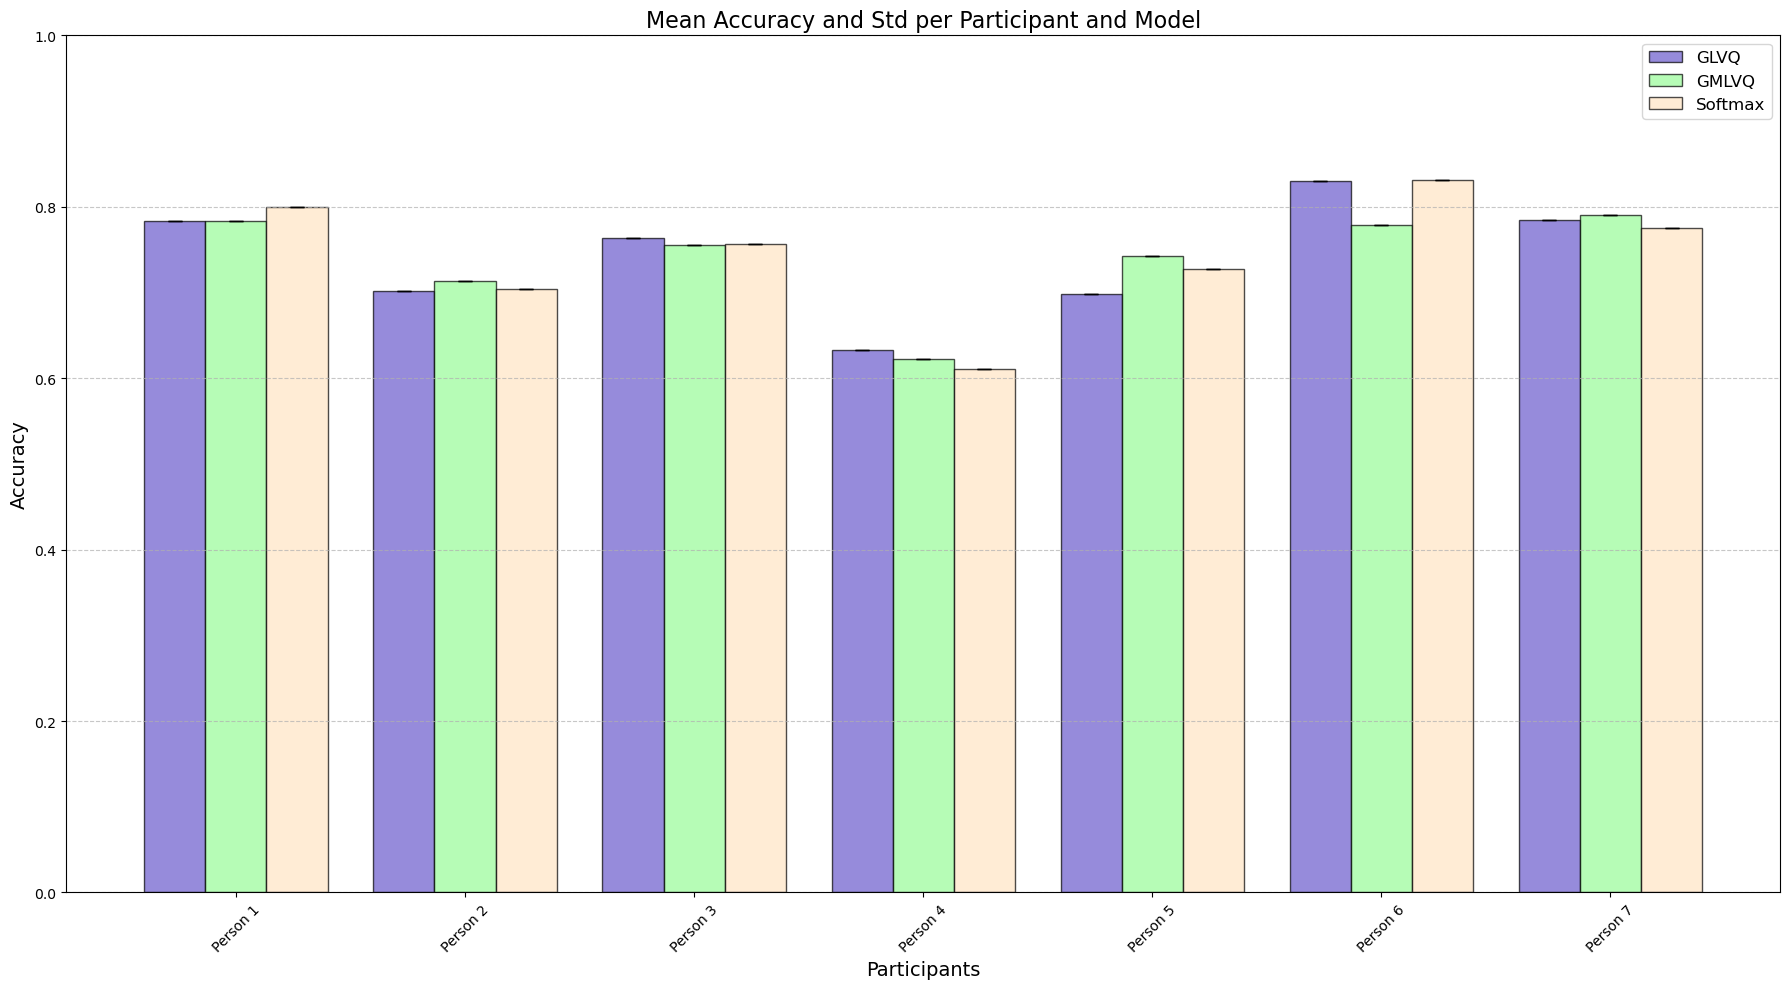

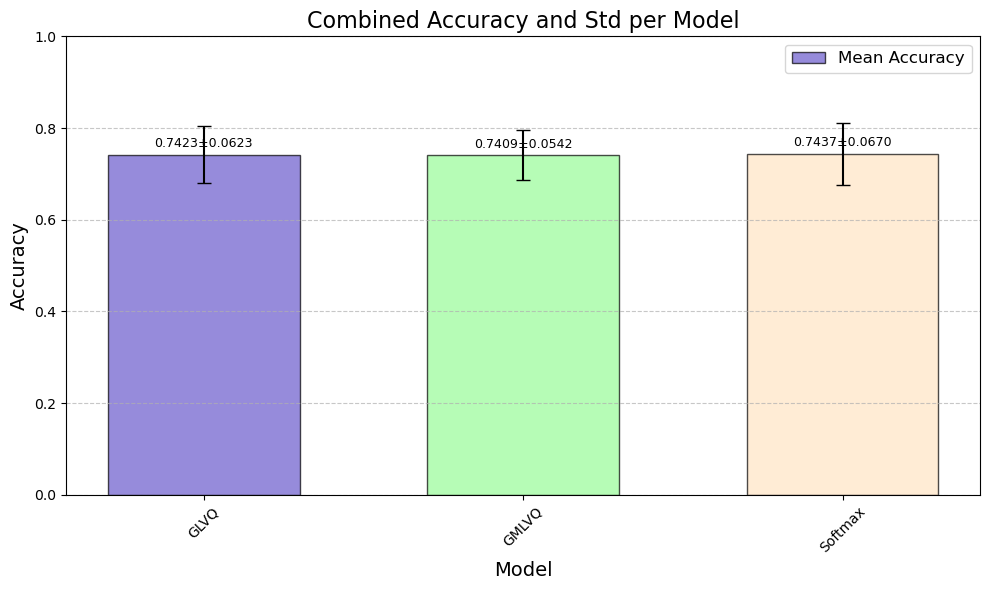

In [62]:
root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/ninapro_basic"

model_names = ["GLVQ", "GMLVQ", "Softmax"]
    
# Sammle die Accuracy-Werte
all_accuracies_dict = collect_accuracies(root_directory, models=model_names)

print(all_accuracies_dict)

# Removes person3, person6 and person8 from the dictionary 
all_accuracies_dict.pop("person2", None)
all_accuracies_dict.pop("person5", None)
all_accuracies_dict.pop("person7", None)



# Erstelle den gruppierten Plot ohne Max/Min Pfeile
plot_grouped_accuracies(all_accuracies_dict, model_names=model_names, figsize=(18, 10), save_path=None)

# Erstelle den kombinierten Plot für alle Modelle
plot_combined_accuracies(all_accuracies_dict, model_names=model_names, figsize=(10, 6), save_path=None)

In [50]:
import os
import pandas as pd
import numpy as np
import ast
import re  # Importiere das re-Modul für reguläre Ausdrücke

def collect_accuracy_statistics(root_dir, models=["GLVQ", "GMLVQ"], k_shots=[1, 2, 5, 10, 20, 40]):
    combined_stats = {model: {k: [] for k in k_shots} for model in models}
    pattern = re.compile(r'^model_(GLVQ|GMLVQ)_K_Shot_(\d+).csv$', re.IGNORECASE)
    
    # Durchlaufe alle Personen-Ordner
    for person_name in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_name)
        
        # Überprüfen, ob es sich um einen Ordner handelt (Personen-Ordner)
        if os.path.isdir(person_path):
            
            # Durchlaufe alle Modellordner innerhalb des aktuellen Personen-Ordners
            for model_folder in os.listdir(person_path):
                model_folder_path = os.path.join(person_path, model_folder)
                
                # Überprüfen, ob es sich um einen Ordner handelt
                if os.path.isdir(model_folder_path):
                    # Verwende reguläre Ausdrücke zur Extraktion von model_name und k_shot_number
                    match = pattern.match(model_folder)
                    if match:
                        model_name = match.group(1).upper()  # GLVQ oder GMLVQ
                        k_shot_str = match.group(2)
                        k_shot_number = int(k_shot_str)
                        if model_name in models and k_shot_number in k_shots:
                            # Pfad zur CSV-Datei (ohne history-Ordner)
                            csv_file = os.path.join(model_folder_path, "training_history.csv")
                            
                            # Überprüfen, ob die CSV-Datei existiert
                            if os.path.isfile(csv_file):
                                # Lade die CSV-Datei
                                df = pd.read_csv(csv_file)
                                
                                # Überprüfen, ob die "accuracy" Spalte vorhanden ist
                                if "accuracy" in df.columns:
                                    # Extrahiere die Accuracy-Strings
                                    acc_strings = df["accuracy"].dropna().tolist()
                                    
                                    acc_values = []
                                    for acc_str in acc_strings:
                                        # Wandelt den String in eine Liste um
                                        acc_list = ast.literal_eval(acc_str)
                                        if isinstance(acc_list, list):
                                            acc_values.extend(acc_list)
                                        elif isinstance(acc_list, (float, int)):
                                            acc_values.append(acc_list)
                                    
                                    if len(acc_values) > 0:
                                        mean_acc = np.mean(acc_values)
                                        # Füge den Mittelwert zur entsprechenden Kombination hinzu
                                        combined_stats[model_name][k_shot_number].append(mean_acc)
    
    # Berechne den übergreifenden Mean und Std für jede Kombination
    results = []
    for model in models:
        for k in k_shots:
            accuracies = combined_stats[model][k]
            if len(accuracies) > 0:
                overall_mean = np.mean(accuracies)
                overall_std = np.std(accuracies)
                results.append({
                    "Modell": model,
                    "K_Shot": k,
                    "Mean Accuracy": overall_mean,
                    "Std Accuracy": overall_std
                })
            else:
                results.append({
                    "Modell": model,
                    "K_Shot": k,
                    "Mean Accuracy": None,
                    "Std Accuracy": None
                })
    
    # Erstelle ein DataFrame für eine übersichtliche Darstellung
    df_results = pd.DataFrame(results)
    
    return df_results

def print_accuracy_statistics(df):
    """
    Gibt die Accuracy-Statistiken aus dem DataFrame übersichtlich aus.

    Args:
        df (pd.DataFrame): DataFrame mit den Spalten ["Modell", "K_Shot", "Mean Accuracy", "Std Accuracy"].
    """
    print("\nAccuracy-Statistiken:")
    print(df.to_string(index=False, 
                       formatters={
                           "Mean Accuracy": lambda x: f"{x:.4f}" if pd.notnull(x) else "Keine Daten",
                           "Std Accuracy": lambda x: f"{x:.4f}" if pd.notnull(x) else "Keine Daten"
                       }))

# Definiere das Wurzelverzeichnis, in dem sich die Personen-Ordner befinden
root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/few-shot" 

# Modelle, die im Unterordnernamen erwartet werden
model_names = ["GLVQ", "GMLVQ"]

# K-shot-Zahlen, die im Unterordnernamen erwartet werden
k_shot_numbers = [1, 2, 5, 10, 20, 40]

# Sammle die Accuracy-Statistiken
all_statistics_df = collect_accuracy_statistics(
    root_dir=root_directory,
    models=model_names,
    k_shots=k_shot_numbers
)


# Gib die gesammelten Statistiken aus
print_accuracy_statistics(all_statistics_df)



Accuracy-Statistiken:
Modell  K_Shot Mean Accuracy Std Accuracy
  GLVQ       1        0.5970       0.0522
  GLVQ       2        0.6523       0.0584
  GLVQ       5        0.7270       0.0480
  GLVQ      10        0.7395       0.0574
  GLVQ      20        0.7484       0.0549
  GLVQ      40        0.7579       0.0512
 GMLVQ       1        0.5074       0.0920
 GMLVQ       2        0.5872       0.0720
 GMLVQ       5        0.6566       0.0723
 GMLVQ      10        0.6713       0.0770
 GMLVQ      20        0.6832       0.0757
 GMLVQ      40        0.7005       0.0787


In [51]:
# Definiere das Wurzelverzeichnis, in dem sich die Personen-Ordner befinden
root_directory = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/results/few-shot-ninapro" 

# Modelle, die im Unterordnernamen erwartet werden
model_names = ["GLVQ", "GMLVQ"]

# K-shot-Zahlen, die im Unterordnernamen erwartet werden
k_shot_numbers = [1, 2, 5, 10, 20, 40]

# Sammle die Accuracy-Statistiken
all_statistics_df = collect_accuracy_statistics(
    root_dir=root_directory,
    models=model_names,
    k_shots=k_shot_numbers
)


# Gib die gesammelten Statistiken aus
print_accuracy_statistics(all_statistics_df)



Accuracy-Statistiken:
Modell  K_Shot Mean Accuracy Std Accuracy
  GLVQ       1        0.3463       0.0775
  GLVQ       2        0.3948       0.1344
  GLVQ       5        0.4414       0.1574
  GLVQ      10        0.4721       0.1682
  GLVQ      20        0.4804       0.1701
  GLVQ      40        0.4871       0.1744
 GMLVQ       1        0.2830       0.0561
 GMLVQ       2        0.3465       0.0990
 GMLVQ       5        0.3772       0.1263
 GMLVQ      10        0.3896       0.1370
 GMLVQ      20        0.4136       0.1480
 GMLVQ      40        0.4321       0.1470


# NEW SECTION 
---

In [13]:
import torch
from model.model import CNet2D 

version = "GLVQ"
num_prototypes_per_class = 1
num_classes = 8 
input_dim = 50

model = CNet2D(
    version=version,
    num_prototypes_per_class=num_prototypes_per_class,
    num_classes=num_classes,
    epochs=0,
    optimizer_type="ADAM",
    learning_rate=0.001,
    batch_size=128,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dataset_type="NearLab"
)

model.load_state_dict(torch.load("E:/Dennis_Bachelor/Bachelor_Thesis-main/src/results/prototype_num/person1/model_GLVQ_Prototypes_1/model_state.pth", map_location=model.device))
model.eval()


CNet2D(
  (pool): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 13), stride=(1, 1), padding=(1, 6))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): RReLU(lower=0.125, upper=0.3333333333333333)
    (3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 48, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4))
    (6): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): RReLU(lower=0.125, upper=0.3333333333333333)
    (8): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(48, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [14]:

prototypes = model.classifier.prototypes.detach().cpu().tolist()
prototype_labels = model.classifier.prototype_labels.detach().cpu().tolist()

In [15]:
from model.dataloader import NearlabDatasetLoader
from model.utils import list_files
path = "E:/Dennis_Bachelor/Bachelor_Thesis-main/src/data/nearlab/8features/person1"
files = list_files(path, "csv")
print(files)
loader = NearlabDatasetLoader(files[:2], files[2:])
X_train, y_train, X_val, y_val, X_test, y_test = loader.load_data()

with torch.no_grad():
    features = model.extract_features(X_test.to(model.device)).cpu().tolist()

y_test = y_test.cpu().tolist()

['E:/Dennis_Bachelor/Bachelor_Thesis-main/src/data/nearlab/8features/person1/Nearlab_sbj1_WL512_S128_r1.csv', 'E:/Dennis_Bachelor/Bachelor_Thesis-main/src/data/nearlab/8features/person1/Nearlab_sbj1_WL512_S128_r2.csv', 'E:/Dennis_Bachelor/Bachelor_Thesis-main/src/data/nearlab/8features/person1/Nearlab_sbj1_WL512_S128_r3.csv']


In [16]:

!pip install umap-learn
import umap
!pip install numpy
import numpy as np

# Kombinieren Sie die Datenfeatures und Prototypen
combined_features = np.vstack([features, prototypes])  # Shape: (num_samples + num_prototypes, input_dim)

# Kombinierte Labels
combined_labels = np.concatenate([y_test, prototype_labels])

# Optional: Kennzeichnen Sie Prototypen separat
is_prototype = np.concatenate([np.zeros(len(y_test)), np.ones(len(prototype_labels))])

# Reduzieren der Dimension auf 2D mit UMAP
umap_reducer = umap.UMAP()
embedding = umap_reducer.fit_transform(combined_features)  # Shape: (num_samples + num_prototypes, 2)

# Separieren der Daten und Prototypen
data_embedding = embedding[:len(features)]
prototypes_embedding = embedding[len(features):]



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\dirty\miniconda3\envs\glvq\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


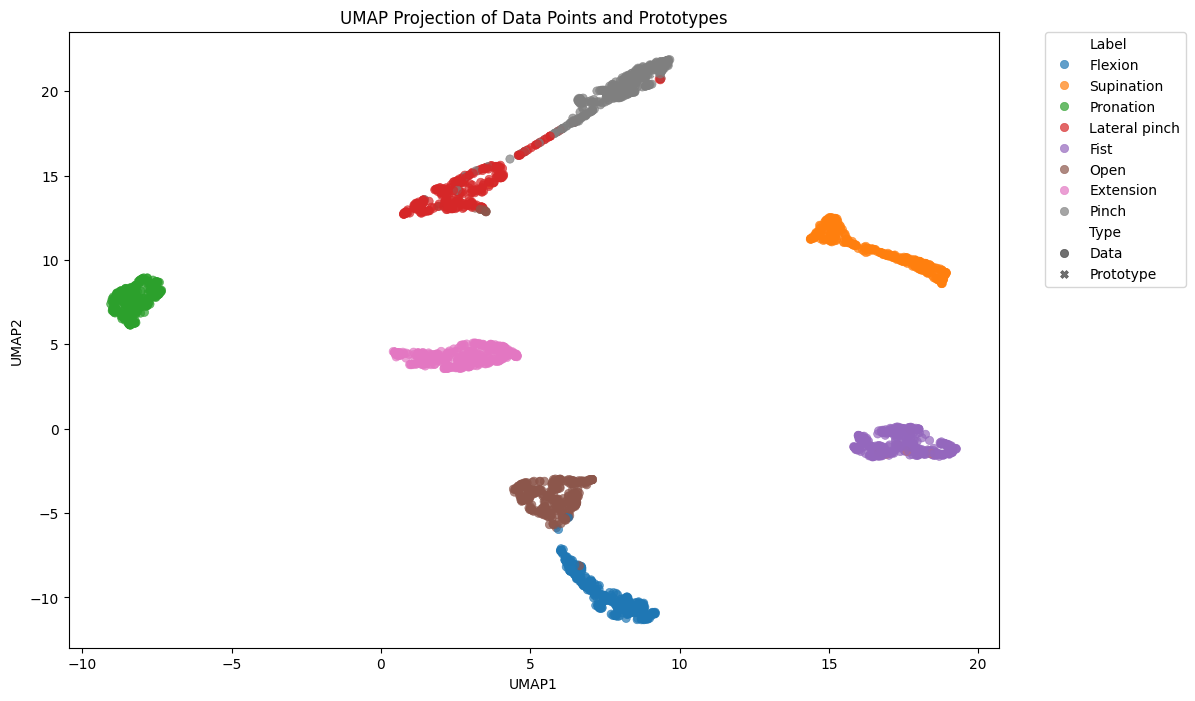

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definieren Sie die Klassennamen (passen Sie sie an Ihre Daten an)
class_names = ["Flexion", "Extension", "Supination", "Pronation", 
               "Open", "Pinch", "Lateral pinch", "Fist"]

# Erstellen Sie ein DataFrame für die Datenpunkte
data_df = pd.DataFrame({
    "UMAP1": data_embedding[:, 0],
    "UMAP2": data_embedding[:, 1],
    "Label": [class_names[label] for label in y_test],
    "Type": "Data"
})

# Erstellen Sie ein DataFrame für die Prototypen
proto_df = pd.DataFrame({
    "UMAP1": prototypes_embedding[:, 0],
    "UMAP2": prototypes_embedding[:, 1],
    "Label": [class_names[label] for label in prototype_labels],
    "Type": "Prototype"
})

# Kombinieren Sie beide DataFrames
combined_df = pd.concat([data_df, proto_df], ignore_index=True)

# Plotten
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_df,
    x="UMAP1",
    y="UMAP2",
    hue="Label",
    style="Type",
    palette="tab10",
    alpha=0.7,
    edgecolor=None
)
plt.title("UMAP Projection of Data Points and Prototypes")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


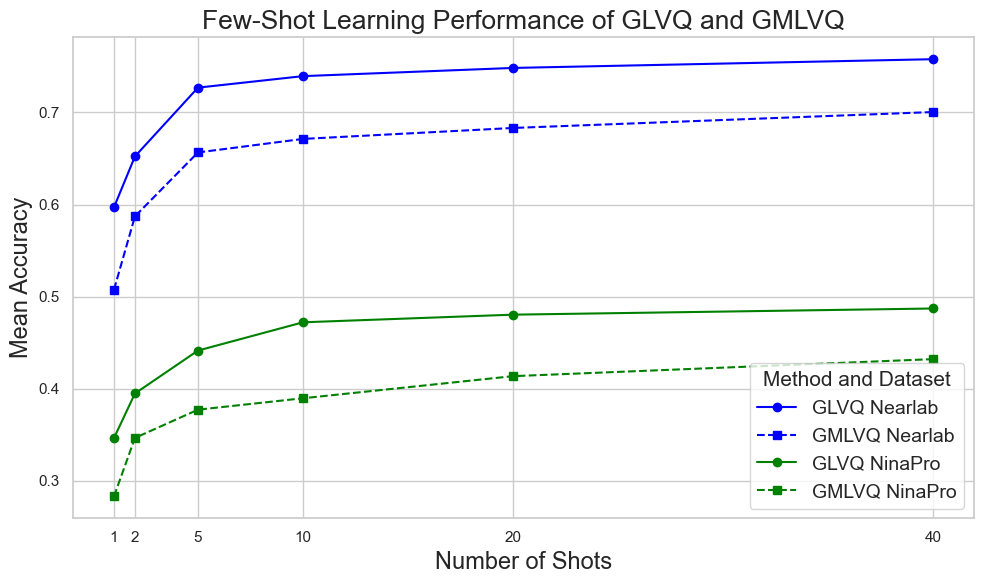

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data based on your Few-Shot Learning results
shots = [1, 2, 5, 10, 20, 40]

# GLVQ and GMLVQ mean accuracies for Nearlab and NinaPro datasets
glvq_nearlab = [0.5970, 0.6523, 0.7270, 0.7395, 0.7484, 0.7579]
gmlvq_nearlab = [0.5074, 0.5872, 0.6566, 0.6713, 0.6832, 0.7005]
glvq_ninapro = [0.3463, 0.3948, 0.4414, 0.4721, 0.4804, 0.4871]
gmlvq_ninapro = [0.2830, 0.3465, 0.3772, 0.3896, 0.4136, 0.4321]

# Create a DataFrame for easier handling (optional)
data = {
    'Shots': shots,
    'GLVQ_Nearlab': glvq_nearlab,
    'GMLVQ_Nearlab': gmlvq_nearlab,
    'GLVQ_NinaPro': glvq_ninapro,
    'GMLVQ_NinaPro': gmlvq_ninapro
}

df = pd.DataFrame(data)

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each method-dataset combination
plt.plot(df['Shots'], df['GLVQ_Nearlab'], marker='o', linestyle='-', color='blue', label='GLVQ Nearlab')
plt.plot(df['Shots'], df['GMLVQ_Nearlab'], marker='s', linestyle='--', color='blue', label='GMLVQ Nearlab')
plt.plot(df['Shots'], df['GLVQ_NinaPro'], marker='o', linestyle='-', color='green', label='GLVQ NinaPro')
plt.plot(df['Shots'], df['GMLVQ_NinaPro'], marker='s', linestyle='--', color='green', label='GMLVQ NinaPro')

# Set plot title and labels
plt.title('Few-Shot Learning Performance of GLVQ and GMLVQ', fontsize=19)
plt.xlabel('Number of Shots', fontsize=17)
plt.ylabel('Mean Accuracy', fontsize=17)

# Set x-axis to log scale if desired (optional)
# plt.xscale('log')

# Set x-ticks to match the shots
plt.xticks(shots)

# Add legend
plt.legend(title='Method and Dataset', fontsize=14, title_fontsize=15)

# Improve layout
plt.tight_layout()

# Save the plot as a high-resolution PNG file
plt.savefig('fewshot_learning_combined.png', dpi=300)

# Display the plot
plt.show()
